<a href="https://colab.research.google.com/github/Vinneypohh/otus-rl/blob/main/mdp_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium gymnasium[toy-text]

In [74]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time


class QLearningAgent:
    def __init__(
        self,
        n_states,
        n_actions,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9996,
        epsilon_min=0.01
    ):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha          # Learning rate
        self.gamma = gamma          # Discount factor
        self.epsilon = epsilon      # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = np.zeros((n_states, n_actions))


    def choose_action(self, state, is_training=True):
        """Choose an action using epsilon-greedy policy."""
        eps = self.epsilon if is_training else 0.0
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)  # Exploration
        return np.argmax(self.q_table[state])          # Exploitation


    def update(self, state, action, reward, next_state):
        """Update Q-table using the Q-learning update rule."""
        best_next_q = np.max(self.q_table[next_state, :])
        td_target = reward + self.gamma * best_next_q
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error


    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    def save(self, filename):
        """Save the learned Q-table to disk."""
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)
        print(f"Agent saved to {filename}")


    def load(self, filename):
        """Load a previously saved Q-table from disk."""
        if os.path.exists(filename):
            with open(filename, "rb") as f:
                self.q_table = pickle.load(f)
            print(f"Agent loaded from {filename}")
        else:
            print("Save file not found.")


def train_agent(episodes, agent_path, render=False):
    """Train a Q-learning agent in Taxi-v3."""
    render_mode = 'human' if render else None
    env = gym.make('Taxi-v3', render_mode=render_mode)

    agent = QLearningAgent(
        n_states=env.observation_space.n,
        n_actions=env.action_space.n
    )

    rewards_history = []

    print(f"Training started ({episodes} episodes)...")
    for i in range(episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = agent.choose_action(state, is_training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        rewards_history.append(total_reward)

        if (i + 1) % 500 == 0:
            avg_rew = np.mean(rewards_history[-100:])
            print(f"Episode {i+1}, Epsilon: {agent.epsilon:.3f}, Avg reward (last 100): {avg_rew:.2f}")

    env.close()
    agent.save(agent_path)
    return rewards_history


def plot_results(rewards, plot_path=None):
    """Plot moving average reward (window=100) and save the figure."""
    window_size = 100
    moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg, label='Average reward (100-episode window)', color='orange')
    plt.title('Taxi-v3 Q-learning training')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.legend()
    if plot_path:
      plt.savefig(plot_path)
    plt.show()


def test_agent(episodes, agent_path, jupyter_mode=False):
    """Run the trained agent to visually inspect behavior."""
    print("\n--- TEST RUN ---")
    render_mode = 'human' if not jupyter_mode else None
    env = gym.make('Taxi-v3', render_mode=render_mode)

    agent = QLearningAgent(env.observation_space.n, env.action_space.n)
    agent.load(agent_path)
    rewards_history = []

    for i in range(episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        print(f"Episode {i+1} started...")

        while not terminated and not truncated:
            # is_training=False => purely greedy actions (no exploration)
            action = agent.choose_action(state, is_training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

        print(f"Episode {i+1} finished. Reward: {total_reward}")
        if not jupyter_mode:
          time.sleep(1)  # Pause between episodes
        rewards_history.append(total_reward)

    env.close()
    return rewards_history


In [67]:
plot_path = 'taxi_training.png'
agent_path = "taxi_agent.pkl"

In [59]:
rewards = train_agent(episodes=10000, agent_path=agent_path, render=False)


Training started (10000 episodes)...
Episode 500, Epsilon: 0.819, Avg reward (last 100): -554.13
Episode 1000, Epsilon: 0.670, Avg reward (last 100): -186.10
Episode 1500, Epsilon: 0.549, Avg reward (last 100): -62.65
Episode 2000, Epsilon: 0.449, Avg reward (last 100): -42.16
Episode 2500, Epsilon: 0.368, Avg reward (last 100): -24.18
Episode 3000, Epsilon: 0.301, Avg reward (last 100): -14.82
Episode 3500, Epsilon: 0.247, Avg reward (last 100): -12.13
Episode 4000, Epsilon: 0.202, Avg reward (last 100): -3.33
Episode 4500, Epsilon: 0.165, Avg reward (last 100): -3.26
Episode 5000, Epsilon: 0.135, Avg reward (last 100): 0.64
Episode 5500, Epsilon: 0.111, Avg reward (last 100): 0.84
Episode 6000, Epsilon: 0.091, Avg reward (last 100): 2.12
Episode 6500, Epsilon: 0.074, Avg reward (last 100): 3.91
Episode 7000, Epsilon: 0.061, Avg reward (last 100): 5.27
Episode 7500, Epsilon: 0.050, Avg reward (last 100): 5.55
Episode 8000, Epsilon: 0.041, Avg reward (last 100): 5.30
Episode 8500, Epsi

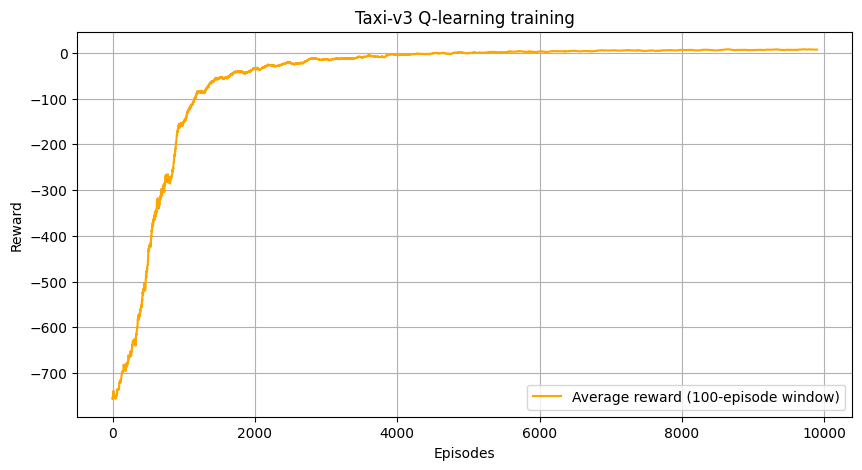

In [68]:
plot_results(rewards)

In [75]:
test_rewards = test_agent(episodes=100, agent_path=agent_path, jupyter_mode=True)


--- TEST RUN ---
Agent loaded from taxi_agent.pkl
Episode 1 started...
Episode 1 finished. Reward: 4
Episode 2 started...
Episode 2 finished. Reward: 5
Episode 3 started...
Episode 3 finished. Reward: 8
Episode 4 started...
Episode 4 finished. Reward: 6
Episode 5 started...
Episode 5 finished. Reward: 8
Episode 6 started...
Episode 6 finished. Reward: 12
Episode 7 started...
Episode 7 finished. Reward: 5
Episode 8 started...
Episode 8 finished. Reward: 10
Episode 9 started...
Episode 9 finished. Reward: 9
Episode 10 started...
Episode 10 finished. Reward: 7
Episode 11 started...
Episode 11 finished. Reward: 6
Episode 12 started...
Episode 12 finished. Reward: 11
Episode 13 started...
Episode 13 finished. Reward: 4
Episode 14 started...
Episode 14 finished. Reward: 8
Episode 15 started...
Episode 15 finished. Reward: 8
Episode 16 started...
Episode 16 finished. Reward: 9
Episode 17 started...
Episode 17 finished. Reward: 7
Episode 18 started...
Episode 18 finished. Reward: 5
Episode 19

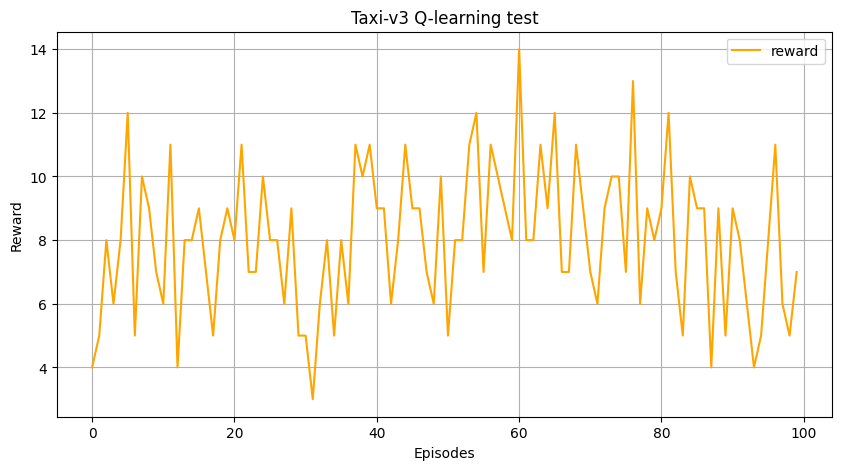

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, label='reward', color='orange')
plt.title('Taxi-v3 Q-learning test')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid(True)
plt.legend()
if plot_path:
  plt.savefig(plot_path)
plt.show()